In [102]:
from prophet import Prophet
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays

In [103]:
training_upto = 2019
forecast_upto = (2023-training_upto-1)*12 + 3

In [109]:
# Read data, get dataframe with crimes/month
df = pd.read_parquet('C:\\Users\\20203697\\Desktop\\JBG050_DC2\\DBL2_data\\cleaned\\Metropolitan-street.parquet')
monthly_grouped_df = df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime ID'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()

# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Crime ID':'nr of burglaries'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
monthly_grouped_df = monthly_grouped_df[(monthly_grouped_df['Year']>2011) | ((monthly_grouped_df['Year'] == 2011) & (monthly_grouped_df['Month num']==12))]
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['Date'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df = monthly_grouped_df.set_index(pd.DatetimeIndex(monthly_grouped_df['Date']))
monthly_grouped_df['ds'] = monthly_grouped_df['Date']
monthly_grouped_df['y'] = monthly_grouped_df['nr of burglaries']

# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

C:\Users\20203697\AppData\Local\Temp\ipykernel_15760\1189812.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20203697\AppData\Local\Temp\ipykernel_15760\1189812.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20203697\AppData\Local\Temp\ipykernel_15760\1189812.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20203697\AppData\Local\Temp\ipykernel_15760\1189812.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20203697\AppData\Local\Temp\ipykernel_15760\1189812.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [111]:
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.05, 0.01, 0.15],
    'seasonality_prior_scale': [0.05, 0.01, 0.15],
    'holidays_prior_scale':[0.005,0.01,0.015],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2022-03-01', freq='2MS')
df_cv = cross_validation(model= my_model, cutoffs=cutoffs, horizon = '365 days')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

  0%|          | 0/44 [00:00<?, ?it/s]

00:47:32 - cmdstanpy - INFO - Chain [1] start processing
00:47:32 - cmdstanpy - INFO - Chain [1] done processing
00:47:32 - cmdstanpy - INFO - Chain [1] start processing
00:47:32 - cmdstanpy - INFO - Chain [1] done processing
00:47:32 - cmdstanpy - INFO - Chain [1] start processing
00:47:33 - cmdstanpy - INFO - Chain [1] done processing
00:47:33 - cmdstanpy - INFO - Chain [1] start processing
00:47:33 - cmdstanpy - INFO - Chain [1] done processing
00:47:33 - cmdstanpy - INFO - Chain [1] start processing
00:47:33 - cmdstanpy - INFO - Chain [1] done processing
00:47:34 - cmdstanpy - INFO - Chain [1] start processing
00:47:35 - cmdstanpy - INFO - Chain [1] done processing
00:47:35 - cmdstanpy - INFO - Chain [1] start processing
00:47:35 - cmdstanpy - INFO - Chain [1] done processing
00:47:36 - cmdstanpy - INFO - Chain [1] start processing
00:47:36 - cmdstanpy - INFO - Chain [1] done processing
00:47:36 - cmdstanpy - INFO - Chain [1] start processing
00:47:37 - cmdstanpy - INFO - Chain [1]

Mean absolute error:  18
Best parameters {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.15, 'seasonality_prior_scale': 0.05, 'holidays_prior_scale': 0.005}


00:13:09 - cmdstanpy - INFO - Chain [1] start processing
00:13:10 - cmdstanpy - INFO - Chain [1] done processing


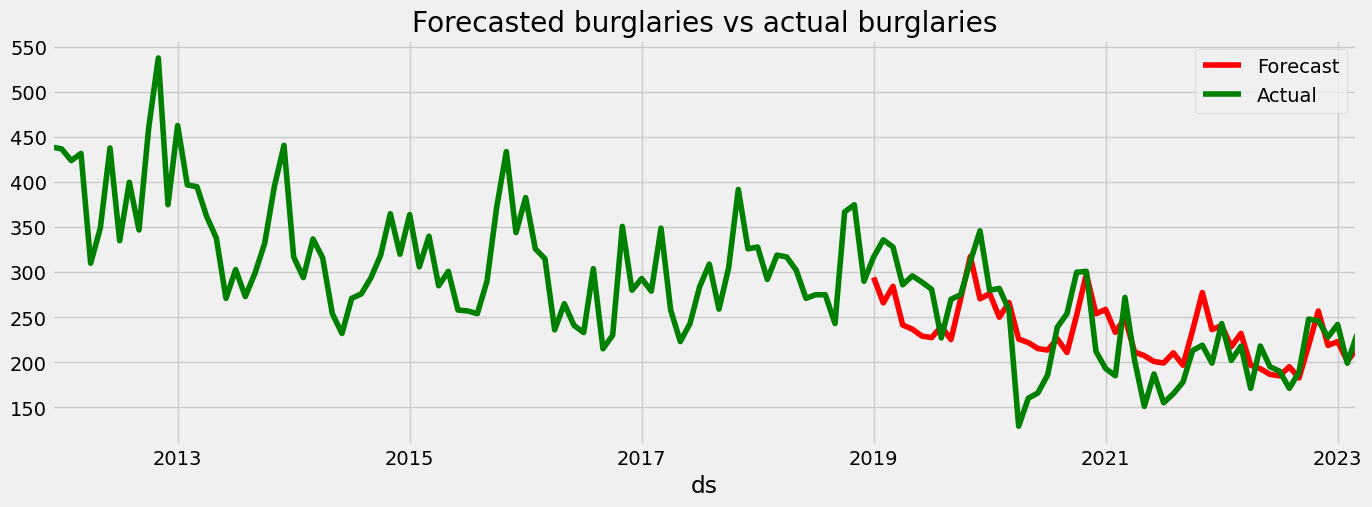

In [107]:
# Train the model with the best parameters and forecast

best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.05, holidays_prior_scale= 0.015, holidays= holiday).fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries')
plt.show()